# Ad Campaign Bayesian A/B Test and Analysis
#### by Justin R. Papreck

*This dataset comes from https://www.kaggle.com/datasets/farhadzeynalli/online-advertising-effectiveness-study-ab-testing by Farhad Zeynalli*

---

**Background**
A large company with a substantial user base plans to increase sales through advertisement on its website. However, they are undecided about whether the ads increase sales or not. In order to determine whether this is the case, 20,000 customers were subjected to A/B testing for 31 days. Prior to the A/B testing, the company has reported an approximate 3% conversion, which is enough information to use as a _prior_ for the Bayesian analysis.  

Each customer was assigned a unique identifier, and the groups were split in a 60:40 ratio, with the larger group seeing the new advertisement and the smaller group seeing a public service announcement (psa) in its place. The outcome measured was whether the client made a purchase, delivered as a boolean statement. Additional parameters and metrics collected included the day of the month the user saw the most ads, the hour of the day the user saw the most ads, and the total number of ads seen by each user. 

The company has contracted the analysis out with the above information. 

**New Analysis**
I have previously used these data in the project [Ad Campaign A/B Testing and Recommendations](https://github.com/FreshOats/Marketing_Analysis), using a traditional Z-test to determine whether there was a statistical difference between the two groups. In this case, because we have information about prior behavior, we have a prior probability that can be used in coordination with a Beta Distribution for our analysis. In this case, we can use a weak prior, Beta(3,97) representing the 3 conversions and 97 non-conversions. Since we have collected 20,000 customers' data, the updated $\alpha$ and $\beta$ values will strengthen the distributions based on our prior. Additionally, since this A/B test is only examining a sample of 20,000 people, there is a chance, albeit very low given our previous test, that the sample is not truly representative of the population. To account for this, I am using a Monte Carlo simulation to add variance to the sample to get a broader distribution. 

One benefit that comes from this use of Bayes' Theory in conjunction with the Monte Carlo simulation is that not only can we determine **if** there is a significant difference, or ideally whether the new ad campaign is significantly better, we can also show **how much** better or worse the new ad campaign is compared to that of the psa. 


---
## Bayes' Theorem

The idea behind Bayesian statistics is that it is possible to arrive at the probability of event A given B occured, P(A|B), using the probability of event B given A, P(B|A). This allows us to use the probability of an observation given a belief to determining the strength of that belief given the observation (Kurt, 2019). 

P(A|B) = P(B|A) * P(A) / P(B)

or in terms reflected as above: 

P(belief | obervations) = P(observations | belief) * P(belief) / P(observations)

P(belief | observations) == "Posterior"
P(observations | belief) == "Likelihood"
P(belief) == "Prior Probability" or "Prior"
P(observation) == "Normalizes Probabilities"

**The Prior Probability**
If we don't know the exact prior probability, then a Beta distribution can be used to represent a family of probability distributions for binomial distributions. The Beta distribution provides instead of a single probability, a function of conversion rates and associated densities. So our prior distribution would be as follows: 

Beta($\alpha$<sub>prior</sub>, $\beta$<sub>prior</sub>)

where $\alpha$ is the number of conversions and $\beta$ is the number of non-conversions

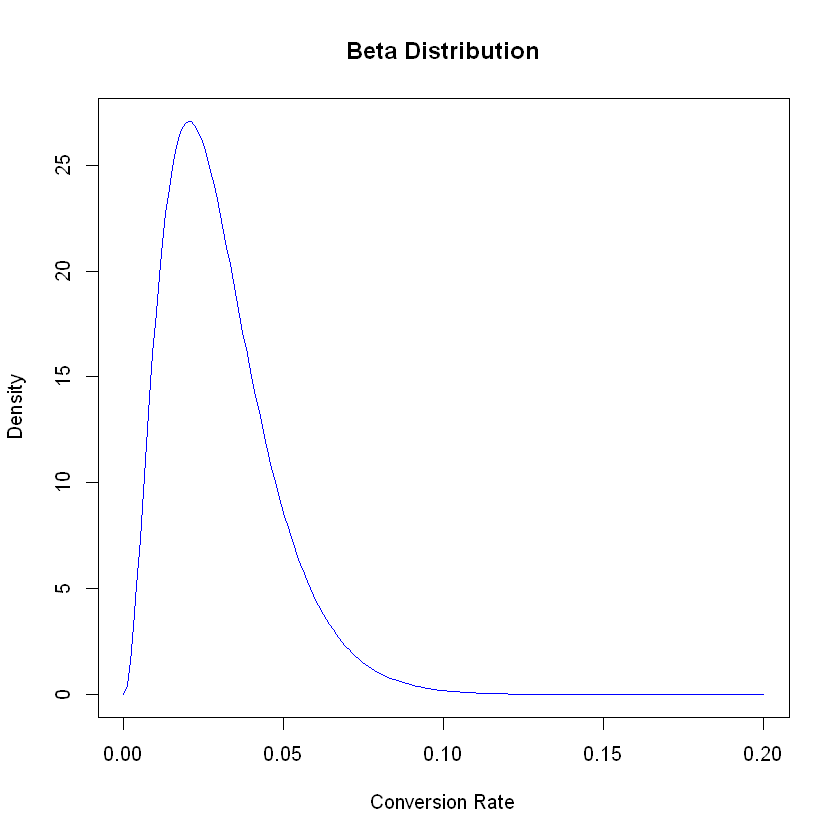

In [24]:
# define range
p <- seq(0, .2, length = 200)

# create a plot of the Beta of 3, 97

alpha <- 3
beta <- 97

plot(p, dbeta(p, alpha, beta), type = "l", ylab = 'Density', xlab = 'Conversion Rate', col='blue', main='Beta Distribution')

This same nomenclature is used for the likelihood and the poseterior. 
So applying Bayes' Theorem to the Beta Distribution, we get the following: 

**Beta($\alpha$<sub>posterior</sub>, $\beta$<sub>posterior</sub>) = Beta($\alpha$<sub>prior</sub> + $\alpha$<sub>likelihood</sub>, $\beta$<sub>prior</sub> + $\beta$<sub>likelihood</sub>)**

Since we will have 2 groups, group **A** and group **B**, or in our case **Ad** and **PSA**, there will be 2 different Beta distributions using the same prior distribution for each, but then the observations will provide the likelihoods of choosing A and choosing B, which are added to the priors. 

---
## Monte Carlo Simulations

In the case where there is an overlap in the probability distributions, there is the introduction of the possibility that the true probability for B is higher than the true probability of A or _vice versa_. The Monte Carlo simulation uses random sampling such that the samples in the high-probability region occur more frequently than those in low-probability regions in _n_ number of simulations. The rbeta() function in R allows us to generate random numers from the beta density with _n_ trials, returning our A and B samples. Using these values we can show the distribution of the probability that A is better/worse than B. 